In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

batch_size=128
num_epochs=20

In [10]:
#Data loading and augmentation
#Try training without random rotation this time
augmentations = transforms.Compose([transforms.RandomHorizontalFlip(),transforms.RandomCrop(32,padding=4),transforms.RandomApply([transforms.RandomRotation(15)]),
                                   transforms.ToTensor(),transforms.Normalize((0.0,0.0,0.0),(1.0,1.0,1.0))])
test_tf = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.0,0.0,0.0),(1.0,1.0,1.0))])
trainset = torchvision.datasets.CIFAR10(root='./cifardata',train=True,download=True,transform=augmentations)
testset = torchvision.datasets.CIFAR10(root='./cifardata',train=False,download=True,transform=test_tf)
trainval = torchvision.datasets.CIFAR10(root='./cifardata',train=True,download=True,transform=test_tf)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True,num_workers=4)
testloader = torch.utils.data.DataLoader(testset,batch_size=batch_size,shuffle=False,num_workers=4)
evalloader = torch.utils.data.DataLoader(trainval,batch_size=batch_size,shuffle=False,num_workers=4)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [11]:
class ID_Block(nn.Module):
    def __init__(self,channels):
        super(ID_Block,self).__init__()
        self.conv1 = nn.Conv2d(channels,channels,3,padding=1,bias=False) #Bias terms are added by the batchnorm layer
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels,channels,3,padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(channels)
    
    def forward(self,x):
        out = self.conv1(x)
        out = F.relu(self.bn1(out))
        out = self.conv2(out)
        out = self.bn2(out)
        out += x
        out = F.relu(out)
        return out
    
class Conv_Block(nn.Module):
    def __init__(self,inchannels,outchannels):
        super(Conv_Block,self).__init__()
        self.conv1 = nn.Conv2d(inchannels,outchannels,3,stride=2,padding=1,bias=False)
        self.bn1 = nn.BatchNorm2d(outchannels)
        self.conv2 = nn.Conv2d(outchannels,outchannels,3,padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(outchannels)
        self.conv_residual = nn.Conv2d(inchannels,outchannels,2,stride=2)
        self.bn_residual = nn.BatchNorm2d(outchannels)

    def forward(self,x):
        residual = self.conv_residual(x)
        residual = self.bn_residual(residual)
        out = self.conv1(x)
        out = F.relu(self.bn1(out))
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = F.relu(out)
        return out
    
class ResNet(nn.Module):
    def __init__(self,resblocks):
        super(ResNet,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,padding=1,bias=False)
        self.bn1 = nn.BatchNorm2d(16,track_running_stats=False)
        self.resblocks = resblocks
        self.global_avg_pool = nn.AvgPool2d(8,stride=1)
        self.fc = nn.Linear(64,10)
                
        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,mode='fan_out',nonlinearity='relu')
            elif isinstance(m,nn.BatchNorm2d):
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)
    
    def forward(self,x):
        out = self.conv1(x)
        out = F.relu(self.bn1(out))
        out = self.resblocks(out)
        out = self.global_avg_pool(out)
        out = out.view(-1,64)
        out = self.fc(out)
        return out

In [12]:
resblocks = nn.Sequential(ID_Block(16),
                         ID_Block(16),
                         ID_Block(16),
                         ID_Block(16),
                         ID_Block(16),
                         ID_Block(16),
                         ID_Block(16),
                         Conv_Block(16,32),
                         ID_Block(32),
                         ID_Block(32),
                         ID_Block(32),
                         ID_Block(32),
                         ID_Block(32),
                         ID_Block(32),
                         ID_Block(32),
                         Conv_Block(32,64),
                         ID_Block(64),
                         ID_Block(64),
                         ID_Block(64),
                         ID_Block(64),
                         ID_Block(64),
                         ID_Block(64),
                         ID_Block(64))
resnet = ResNet(resblocks)
device = torch.device('cuda')
resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(),lr=0.1,momentum=0.9,weight_decay=0.0001) #See https://arxiv.org/pdf/1705.08292.pdf
scheduler = optim.lr_scheduler.MultiStepLR(optimizer,milestones=[32000,48000])
#optimizer = optim.Adam(resnet.parameters(),weight_decay=0.0001) 

In [13]:
def check_accuracy(loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            inputs,labels = data
            inputs,labels = inputs.to(device),labels.to(device)
            outputs = resnet(inputs)
            _,predicted = torch.max(outputs.data,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return (correct/total)

In [14]:
losses = []
trains = []
evals = []
iters = 0
epochs = 0
while iters < 64000:
    epochs += 1
    for i,data in enumerate(trainloader,0):
        inputs,labels = data
        inputs,labels = inputs.to(device),labels.to(device)
        optimizer.zero_grad()
        outputs = resnet(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.item()
        if i%100==99:
            print('[Epoch %d,Minibatch %d] Running Loss : %.3f' % (epochs,i+1,running_loss/100))
            losses.append(running_loss)
            running_loss = 0
        iters += 1
        
    trainaccuracy = check_accuracy(evalloader)
    evalaccuracy = check_accuracy(testloader)
    print('[Epoch %d] : Training Accuracy : %.3f Test Accuracy %.3f' % (epochs,trainaccuracy,evalaccuracy))
    trains.append(trainaccuracy)
    evals.append(evalaccuracy)

print("TRAINING IS NOW COMPLETE")

[Epoch 1,Minibatch 100] Running Loss : 2.422
[Epoch 1,Minibatch 200] Running Loss : 2.132
[Epoch 1,Minibatch 300] Running Loss : 1.859
[Epoch 1] : Training Accuracy : 0.393 Test Accuracy 0.396
[Epoch 2,Minibatch 100] Running Loss : 3.188
[Epoch 2,Minibatch 200] Running Loss : 1.550
[Epoch 2,Minibatch 300] Running Loss : 1.490
[Epoch 2] : Training Accuracy : 0.488 Test Accuracy 0.484
[Epoch 3,Minibatch 100] Running Loss : 2.649
[Epoch 3,Minibatch 200] Running Loss : 1.261
[Epoch 3,Minibatch 300] Running Loss : 1.192
[Epoch 3] : Training Accuracy : 0.599 Test Accuracy 0.599
[Epoch 4,Minibatch 100] Running Loss : 2.115
[Epoch 4,Minibatch 200] Running Loss : 1.004
[Epoch 4,Minibatch 300] Running Loss : 0.980
[Epoch 4] : Training Accuracy : 0.661 Test Accuracy 0.647
[Epoch 5,Minibatch 100] Running Loss : 1.746
[Epoch 5,Minibatch 200] Running Loss : 0.871
[Epoch 5,Minibatch 300] Running Loss : 0.840
[Epoch 5] : Training Accuracy : 0.697 Test Accuracy 0.687
[Epoch 6,Minibatch 100] Running Los

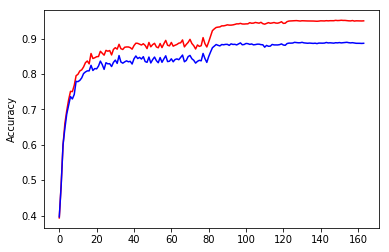

In [15]:
plt.plot(trains,'r')
plt.plot(evals,'b')
plt.ylabel('Accuracy')
plt.show()

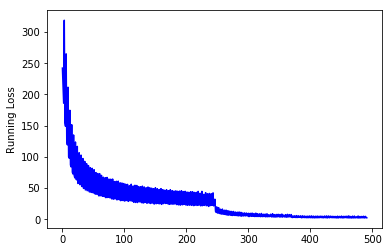

In [16]:
plt.plot(losses,'b')
plt.ylabel('Running Loss')
plt.show()

In [17]:
torch.save(resnet.state_dict(),'RESNET56')